In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Apr 25 17:21:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import shutil

In [ ]:
#shutil.copyfile("/content/gdrive/MyDrive/stat430project/semantic2d/data_2d_semantics.7z", "/content/data_2d_semantics.7z")
!7z x "/content/gdrive/MyDrive/stat430project/semantic2d/data_2d_semantics.7z" -o"/content/"


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/gdrive/MyDrive/stat430project/semantic2d/                                                            1 file, 53486976622 bytes (50 GiB)

Extracting archive: /content/gdrive/MyDrive/stat430project/semantic2d/data_2d_semantics.7z
--
Path = /content/gdrive/MyDrive/stat430project/semantic2d/data_2d_semantics.7z
Type = 7z
Physical Size = 53486976622
Headers Size = 1018194
Method = LZMA2:26
Solid = +
Blocks = 4

  0%      0% 7 - data_2d_semantics/2013_05_28_drive_val_frames.txt                                                          

In [ ]:
# find -name '*.png' | sort -n | # find pngs
# gawk 'BEGIN{ a=1 }{ printf "mv %s %04d.png\n", $0, a++ }' | # build mv command
# bash

In [ ]:
#!cd /content/ && bash /content/gdrive/MyDrive/stat430project/semantic2d/download_2d_perspective.sh

In [ ]:
# !wget "https://s3.eu-central-1.amazonaws.com/avg-projects/KITTI-360/ed180d24c0a144f2f1ac71c2c655a3e986517ed8/data_2d_semantics.zip"
# Pre-process this data so that only the images we  need are there

In [ ]:
# Move zip from drive to local environment
# so that data extraction is easier
#import shutil
#shutil.copyfile("data_2d_semantics.zip", "/content/data_2d_semantics.zip")
#!unzip -q "/content/data_2d_semantics.zip" -d "/content/"

In [ ]:
#pip install git+https://github.com/autonomousvision/kitti360Scripts.git

In [ ]:
#!wget -P "/content/gdrive/MyDrive/stat430project" "https://raw.githubusercontent.com/autonomousvision/kitti360Scripts/master/kitti360scripts/helpers/labels.py"

In [ ]:
#!wget -P "/content/gdrive/MyDrive/stat430project" "https://github.com/autonomousvision/kitti360Scripts/blob/master/kitti360scripts/helpers/annotation.py"

In [ ]:
import torch
from torchvision import datasets, transforms
import helper
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import cv2
import torch.nn as nn

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [ ]:
ignore_index = 255
void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, 36, 38,
                39, 40, 41, 42, 43, 44, -1]

valid_classes = [ignore_index, 7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23,
                 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 37]

class_names = ["unlabelled", "road", "sidewalk", "building", "wall", "fence",
               "pole", "traffic light", "traffic sign", "vegetation",
               "terrain", "sky", "person", "rider", "car", "truck",
               "bus", "train", "motorcycle", "bicycle", "garage", "gate",
               "smallpole"]

class_map = dict(zip(valid_classes, range(len(valid_classes))))
n_classes = len(valid_classes)
class_map

{7: 1,
 8: 2,
 11: 3,
 12: 4,
 13: 5,
 17: 6,
 19: 7,
 20: 8,
 21: 9,
 22: 10,
 23: 11,
 24: 12,
 25: 13,
 26: 14,
 27: 15,
 28: 16,
 31: 17,
 32: 18,
 33: 19,
 34: 20,
 35: 21,
 37: 22,
 255: 0}

In [ ]:
colors = [  [  0,  0,  0],
            [128, 64,128],
            [244, 35,232],
            [250,170,160],
            [ 70, 70, 70],
            [102,102,156],
            [190,153,153],
            [153,153,153],
            [250,170, 30],
            [220,220,  0],
            [107,142, 35],
            [152,251,152],
            [ 70,130,180],
            [220, 20, 60],
            [255,  0,  0],
            [  0,  0,142],
            [  0,  0, 70],
            [  0, 60,100],
            [  0, 80,100],
            [  0,  0,230],
            [119, 11, 32],
            [ 64,128,128],
            [190,153,153],
            [153,153,153]]

In [ ]:
label_colors = dict(zip(range(n_classes), colors))
label_colors

{0: [0, 0, 0],
 1: [128, 64, 128],
 2: [244, 35, 232],
 3: [250, 170, 160],
 4: [70, 70, 70],
 5: [102, 102, 156],
 6: [190, 153, 153],
 7: [153, 153, 153],
 8: [250, 170, 30],
 9: [220, 220, 0],
 10: [107, 142, 35],
 11: [152, 251, 152],
 12: [70, 130, 180],
 13: [220, 20, 60],
 14: [255, 0, 0],
 15: [0, 0, 142],
 16: [0, 0, 70],
 17: [0, 60, 100],
 18: [0, 80, 100],
 19: [0, 0, 230],
 20: [119, 11, 32],
 21: [64, 128, 128],
 22: [190, 153, 153]}

In [ ]:
def encode_segmap(mask):
    #remove unwanted classes and recitify the labels of wanted classes
    for void_class in void_classes:
        mask[mask == void_class] = ignore_index
    for valid_class in valid_classes:
        mask[mask == valid_class] = class_map[valid_class]
    return mask

In [ ]:
def decode_segmap(temp):
    #convert gray scale to color
    temp=temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, n_classes):
        r[temp == l] = label_colors[l][0]
        g[temp == l] = label_colors[l][1]
        b[temp == l] = label_colors[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb

In [ ]:
#! pip install albumentations==0.4.6

In [ ]:
# import albumentations as A
# #from albumentations.pytorch import ToTensorV2
# transform=A.Compose(
# [
#     A.Resize(256, 512),
#     A.HorizontalFlip(),
#     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#     A.pytorch.ToTensorV2(),
# ]
# )



In [ ]:
# transforms = transforms.Compose([
#   transforms.ToTensor(),
#   #transforms.Resize(int(1.15 * imsize)),
#   #transforms.RandomCrop(imsize),
#   #transforms.RandomHorizontalFlip(.5),
#   #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

In [ ]:
from PIL import Image
import numpy as np
import albumentations as A

In [ ]:
class KittiDataset(Dataset):
  def __init__(self, image_dir, mask_dir, transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img_path = os.path.join(self.image_dir, self.images[index])
    mask_path = os.path.join(self.mask_dir, self.images[index])
    image = np.array(Image.open(img_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("RGB"))

    # default size of images is 3 x 1408 x 376

    # img = cv2.imread(self.img[item])
    # mask = cv2.imread(self.mask[item])
    
    if self.transform is not None:
      tran = transforms.Compose([
                                  transforms.ToTensor(),
                                  #transforms.Resize(int(1.15 * imsize)),
                                  #transforms.RandomCrop(imsize),
                                  #transforms.RandomHorizontalFlip(.5),
                                  #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                  ])
      # augmentations = tran(image=image, mask=mask)
      # image = augmentations["image"]
      # mask = augmentations["mask"]
      image = tran(image)
      mask = tran(mask)
    
    return image, mask

In [ ]:
data_2d_train_root = "/content/data_2d_semantics/KITTI-360/data_2d_raw_train"
mask_2d_train_root = "/content/data_2d_semantics/KITTI-360/semantic_mask_train"

data_2d_val_root = "/content/data_2d_semantics/KITTI-360/data_2d_raw_val"
mask_2d_val_root = "/content/data_2d_semantics/KITTI-360/semantic_mask_val"

In [ ]:
train_dataset = KittiDataset(image_dir=data_2d_train_root, mask_dir=mask_2d_train_root, transform=transforms)

val_dataset = KittiDataset(data_2d_val_root, mask_2d_val_root, transform=transforms)

In [40]:
train_data = DataLoader(train_dataset, batch_size=8, shuffle=False, num_workers=1, drop_last=True)
val_data = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=1, drop_last=True)

In [ ]:
def image_show(data_loader,n):

  #Read Augmented image data
  data_iter = iter(data_loader)
  for i in range(1):
    images,labels = data_iter.next()

  #Convert image from tensor to numpy
  images = images.cpu().detach().numpy()

  #Take out n images one by one and display them
  for i in range(n):
    image = np.transpose(images[i],[1,2,0])
    plt.imshow(image, aspect='auto')
    plt.show()

In [ ]:
def mask_show(data_loader, n):

  #Read Augmented image data
  data_iter = iter(data_loader)
  for i in range(1):
    images,labels = data_iter.next()

  #Convert image from tensor to numpy
  labels = labels.cpu().detach().numpy()

  #Take out n images one by one and display them
  for i in range(n):
    label = np.transpose(labels[i], [1,2,0])
    plt.imshow(label, aspect='auto')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


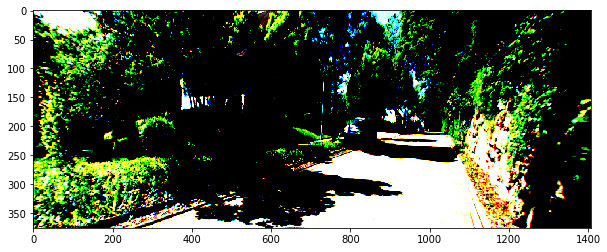

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


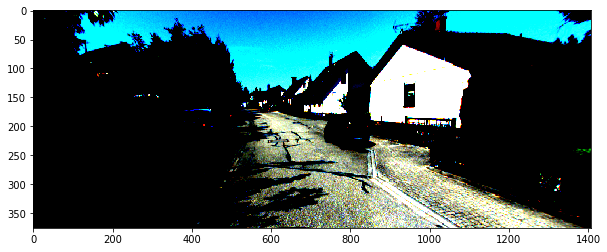

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


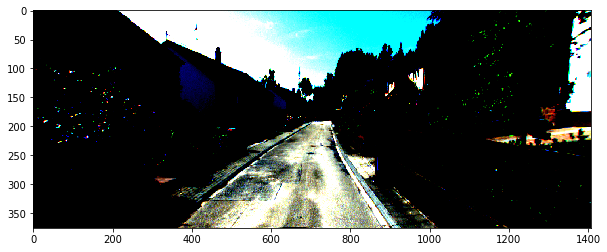

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


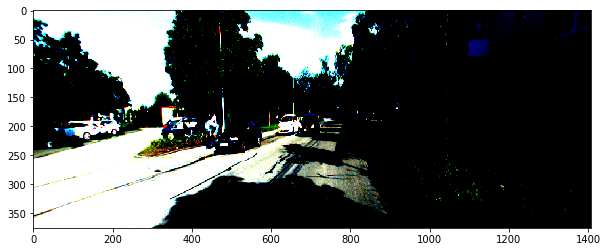

In [41]:
image_show(train_data, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


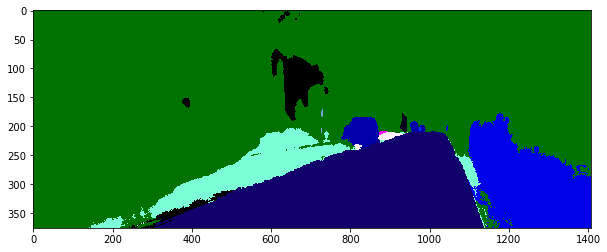

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


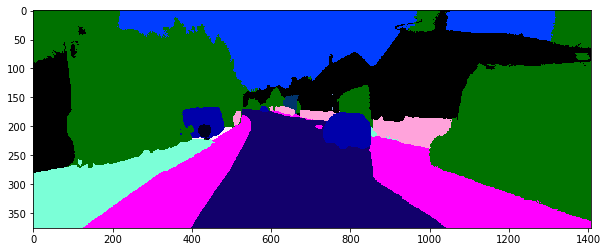

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


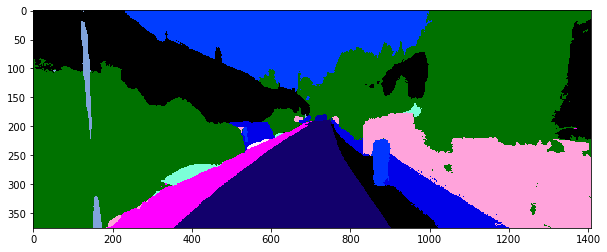

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


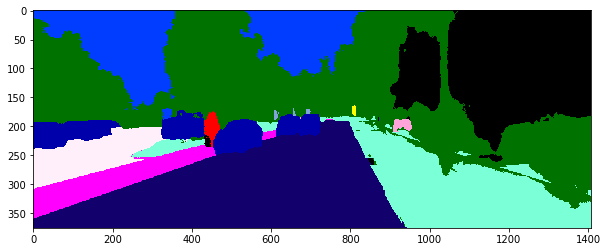

In [42]:
mask_show(train_data, 4)

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [44]:
torch.cuda.is_available()

True

In [45]:
num_epochs = 75

# Load Pretrained DeepLabsV3
classifier = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [46]:
classifier.aux_classifier[4] = nn.Conv2d(256, n_classes, kernel_size=(1,1), stride=(1,1))

In [47]:
classifier.aux_classifier

FCNHead(
  (0): Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(256, 23, kernel_size=(1, 1), stride=(1, 1))
)

In [ ]:
classifier = classifier.to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

In [ ]:
def plot_losses(train, val, num_epochs):
    plt.plot(train, label="train")
    indices = np.arange(num_epochs)
    plt.plot(indices, val, label="val")
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

In [ ]:
losses = []
val_loss = []
for epoch in range(num_epochs):

  for batch_idx, (data_, masks_) in enumerate(train_data):
      data_ = data_.to(device=device, dtype=torch.float32)
      targets = masks_.to(device=device, dtype=torch.long)

      #forward
      scores = classifier(data_)
      loss = criterion(scores, targets)

      losses.append(loss.item())

      #backward
      optimizer.zero_grad()
      loss.backward()

      optimizer.step()

      print(f'Cost at {epoch} epoch is {sum(losses)/len(losses)}')

  with torch.no_grad():
    for j, (input, target) in enumerate(val_data):
      input = input.to(device=device, dtype=torch.float32)
      target = target.to(device=device, dtype=torch.long)

      pred = classifier(input)
      v_loss = criterion(pred, targets)

      val_loss.append(v_loss.item())

In [ ]:
plot_losses(losses, val_loss, num_epochs)